# Drought risk assessment with MODIS NDVI and LST data

Several drought risk metrics exist in the literature, which use a combination of NDVI, Land Surface Temperature (LST) and precipitation data to derive insights on drought potentials of geographical regions. Here, we use NDVI and LST data from MODIS to perform a simple test drought risk assessment of the Trans-Nzoia region. Since MODIS NDVI and LST bands have resolutions of $250$ m and $1000$ m respectively, the data was generated by tiling the bounding box of the region with $1\:\rm{km}^2$ tiles. For each tile, we analyze the resulting NDVI and LST time-series, between the years 2000 and 2024, and calculate the 'Vegetation Health Index' during growing seasons to search for potential drought signals.

In [1]:
!pip install geopandas pymannkendall

  Using cached geopandas-1.1.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached pymannkendall-1.4.3-py3-none-any.whl.metadata (14 kB)
  Using cached pyogrio-0.11.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (5.3 kB)
  Using cached pyproj-3.7.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (31 kB)
  Using cached shapely-2.1.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached geopandas-1.1.1-py3-none-any.whl (338 kB)
Using cached pymannkendall-1.4.3-py3-none-any.whl (12 kB)
Using cached pyogrio-0.11.0-cp312-cp312-manylinux_2_28_x86_64.whl (27.7 MB)
Using cached pyproj-3.7.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
Using cached shapely-2.1.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [geopandas]/5 [geopandas]


In [2]:
import boto3
from io import StringIO
import numpy as np
import pandas as pd
from shapely import Polygon
import geopandas as gpd
import json
from datetime import datetime
import logging 

logging.basicConfig(level=logging.INFO)

In [3]:
bucket_name = "modis-time-series"
key = "MODIS_ndvi_series_Trans_Nzoia_1.csv"

s3 = boto3.client("s3")

## Data cleaning

The data generated by GEE comes in a wide form with rows representing tiles and date columns. The cleaning step consists of converting the data into a long format and imputing missing values via interpolation. Furthermore, MODIS NDVI and LST products have different acquisition frequencies. As a result, the aggregate both on a monthly basis for easier comparison and analysis. These steps are performed by the `clean_MODIS_data()` function, which returns a `df` containing the monthly aggregate time-series per tile and a `gdf` containing the geometries of the tiles.

In [4]:
def clean_ts_data(bucket_name:str, key: str, var: str="ndvi") -> tuple[pd.DataFrame, gpd.GeoDataFrame]:
    """ 
    This function transforms and cleans wide-form time-series data and performs monthly aggregates 
    of the values over the years. The data can come from any GEE product, as long as it is a wide-form
    time-series.

    Args: (i) bucket_name - name of the S3 bucket containing data
          (ii) key - prefix of data file
          (iii) var - type of MODIS data; defaults to `ndvi`

    Returns: (i) df_agg - the monthly aggregated time-series data per tile
             (ii) gdf - geometries of the corresponding tiles
    """

    # Read .csv file directly from S3 bucket
    response = s3.get_object(Bucket=bucket_name, Key=key)
    df = pd.read_csv(
        StringIO(response["Body"].read().decode("utf-8"))
    )

    # Convert .geo from json to shapely Polygon object
    df["geometry"] = df[".geo"].apply(lambda x: Polygon(json.loads(x)["coordinates"][0]))
    gdf = gpd.GeoDataFrame(df["geometry"])
    gdf["tile_name"] = gdf.index 

    if pd.Series(["system:index", ".geo", "geometry"]).isin(df.columns).all():
        df = df.drop(columns=["system:index", ".geo", "geometry"])

    if "tile_name" in df.columns:
        new_cols = ["tile_name"] + [col for col in df.columns if col != "tile_name"]
        df = df.reindex(columns=new_cols)
    else:
        logging.warning("No column named 'tile_name' is present in the dataframe")

    df.iloc[:, 1:] = df.iloc[:, 1:].interpolate(method="linear", axis=1)
    df_melted = df.melt(id_vars="tile_name", var_name="date", value_name=var)
    df_melted["date"] = pd.to_datetime(df_melted["date"])

    # Remove duplicates and sort by tile and date
    df_melted = (
        df_melted.drop_duplicates(subset=["tile_name", "date"], keep="first")
                .sort_values(by=["tile_name", "date"])
                .reset_index(drop=True)
    )

    # Perform monthly aggregate of the data over the entire time span

    df_melted["month"] = df_melted["date"].dt.month
    df_melted["year"] = df_melted["date"].dt.year

    # Check if data already has monthly temporal resolution
    is_monthly = len(df_melted["date"].dt.to_period("M").unique()) == len(df_melted)

    if not is_monthly:
        logging.info("Creating monthly aggregate.")
        df_agg = (
            df_melted.groupby(["tile_name", "year", "month"])[[var]].agg("mean")
            .reset_index()
        )

        start_of_month = pd.to_datetime(df_agg[["year", "month"]].assign(day=1))
        df_agg.insert(3, "date", start_of_month) 

        return df_agg, gdf
    else:
        logging.info("Data already has monthly temporal resolution")

        return df_melted, gdf

In [5]:
df_ndvi, gdf = clean_ts_data(bucket_name=bucket_name, key=key)
df_lst, _ = clean_ts_data(bucket_name=bucket_name, key="MODIS_lst_series_Trans_Nzoia_1.csv", var="lst")

INFO:root:Creating monthly aggregate.
INFO:root:Creating monthly aggregate.


In [6]:
df_merged = df_ndvi.merge(df_lst, on=["tile_name", "year", "month", "date"], how="inner")

## A closer look at NDVI and LST curves

### Cross-correlations
We observe that there is generally a phase difference between NDVI and LST, such that NDVI peaks tend to coincide with LST troughs and vice versa. This indicates that very high temperatures are not conducive to vegetation growth. This phase lag is further exemplified by the cross-correlation plot, where we observe that the peaks and troughs are separated by roughly $6$ time points, corresponding to half a year. These are indications that the NDVI and LST are highly 'out-of-phase' with each other.

The phase difference can be understood by the fact that during the 'green' seasons, canopy cover and evapotranspiration has a natural cooling effect on the environment. The converse is true when the amount of 'green' decreases.

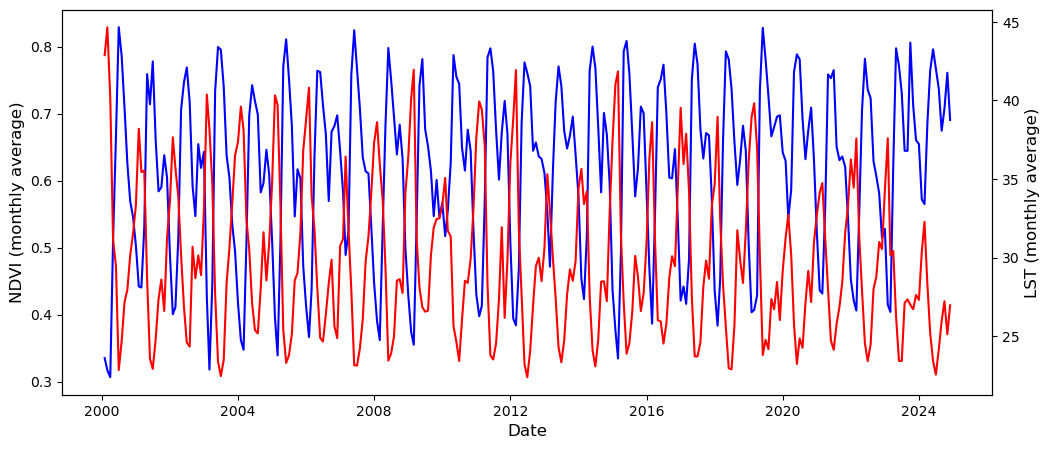

In [7]:
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_palette("bright")

fig, ax1 = plt.subplots(figsize=(12, 5))

sns.lineplot(
    df_ndvi[df_ndvi["tile_name"]==10],
    x="date",
    y="ndvi", 
    color="blue",
    ax=ax1
)

ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("NDVI (monthly average)", fontsize=12)

ax2 = ax1.twinx()

sns.lineplot(
    df_lst[df_lst["tile_name"]==10],
    x="date",
    y="lst", 
    color="red",
    ax=ax2
)

ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("LST (monthly average)", fontsize=12)

plt.show()

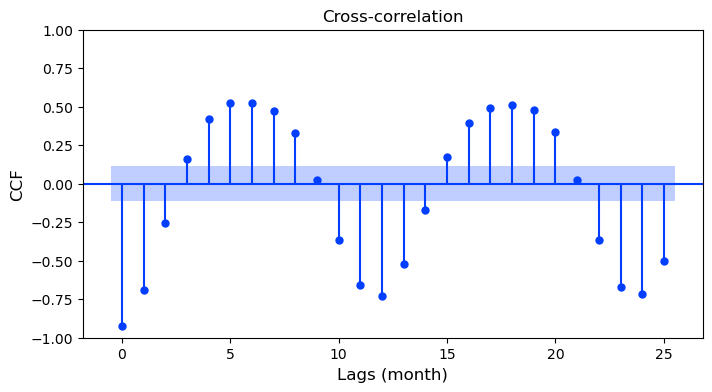

In [8]:
import statsmodels.api as sm 

fig, ax = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_ccf(
    df_ndvi[df_ndvi["tile_name"]==0].ndvi,
    df_lst[df_lst["tile_name"]==0].lst,
    ax=ax
)
ax.set_xlabel("Lags (month)", fontsize=12)
ax.set_ylabel("CCF", fontsize=12)
plt.show()

### Existence of monotonic trends (Mann-Kendall test)

It is also of interest to check whether there exist increasing/decreasing trends in the NDVI and LST time-series over the years of acquisition. One popular statistical method that can test for monotonically increasing/decreasing trends in time-series data is the Mann-Kendall (MK) test. It is a non-parametric test with the null hypothesis $H_0$ that there is no trend in the time-series. In the MK test, the test statistic is the sum of the signs of the differences between points. If a time-series consists of points $x_1, x_2, \cdot\cdot\cdot, x_{n-1}, x_n$, then
$$ S = \sum_{i=1}^{n-1}\sum_{j=i+1}^n\text{sgn}\left( x_j - x_i \right) $$
If $S>0$, then later observations tend to be increasing and vice versa. The original MK test was not designed for time-series data. Here, we use the `pymannkendall` package and its `seasonal_test` method to analyze our data.

In [9]:
import pymannkendall as pymk
def mann_kendall_test(df: pd.DataFrame, var: str="ndvi") -> pd.DataFrame:
    """ 
    This function performs Mann-Kendall test to look for monotonic
    trends in the NDVI and LST data for each tile.
    """
    df_groups = []
    for idx, group in df.groupby("tile_name"):
        test = pymk.seasonal_test(group[var], period=12)
        group["has_trend"] = test.trend 
        group["p_val"] = test.p 
        group["slope"] = test.slope 
        group["intercept"] = test.intercept 

        df_groups.append(group)

    df_w_mk = pd.concat(df_groups).reset_index(drop=True)

    return df_w_mk

In [10]:
df_ndvi_w_mk = mann_kendall_test(df_ndvi)
df_lst_w_mk = mann_kendall_test(df_lst, var="lst")

In [11]:
def plot_trend_grid(
    df_1: pd.DataFrame,
    df_2: pd.DataFrame,
    gdf: gpd.GeoDataFrame
) -> None:

    df_1 = df_1.groupby("tile_name")["has_trend"].agg("first").reset_index()
    df_2 = df_2.groupby("tile_name")["has_trend"].agg("first").reset_index()
    gdf_1 = gpd.GeoDataFrame(
        df_1.merge(gdf, on="tile_name", how="inner")
    )

    gdf_2 = gpd.GeoDataFrame(
        df_2.merge(gdf, on="tile_name", how="inner")
    )

    color_dict = {"increasing": "blue", "no trend": "gray", "decreasing": "red"}
    gdf_1["color_code"] = gdf_1["has_trend"].map(color_dict)
    gdf_2["color_code"] = gdf_2["has_trend"].map(color_dict)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 12), sharey=True)

    gdf_1.plot(color=gdf_1["color_code"], ax=ax1, edgecolor="w", legend=True)
    ax1.set_title("NDVI trend", fontsize=15)
    gdf_2.plot(color=gdf_2["color_code"], ax=ax2, edgecolor="w", legend=True)
    ax2.set_title("LST trend", fontsize=15)

    plt.show()

Surprisingly, the LST data of Trans-Nzoia show a decreasing trend (in red). This might be due to the fact that a the temperature in is in a local dip when viewed against historical temperature data. Furthermore, since the temperature time-series is a monthly aggregate, noise and small term variations could have also played a part in producing such a trend.

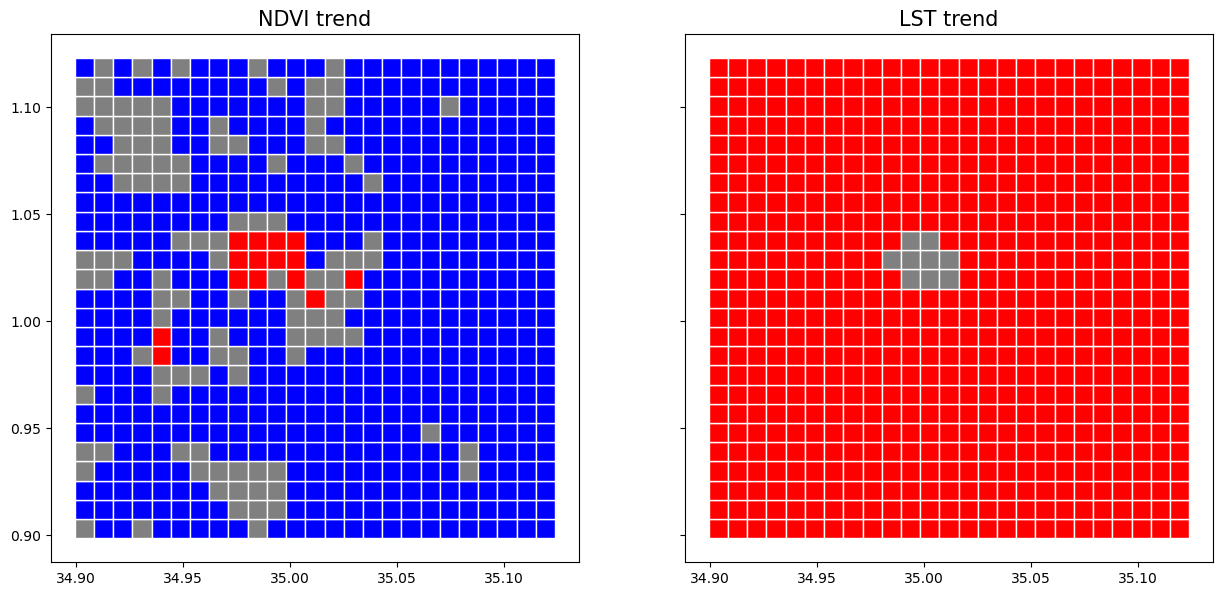

In [12]:
plot_trend_grid(df_ndvi_w_mk, df_lst_w_mk, gdf)

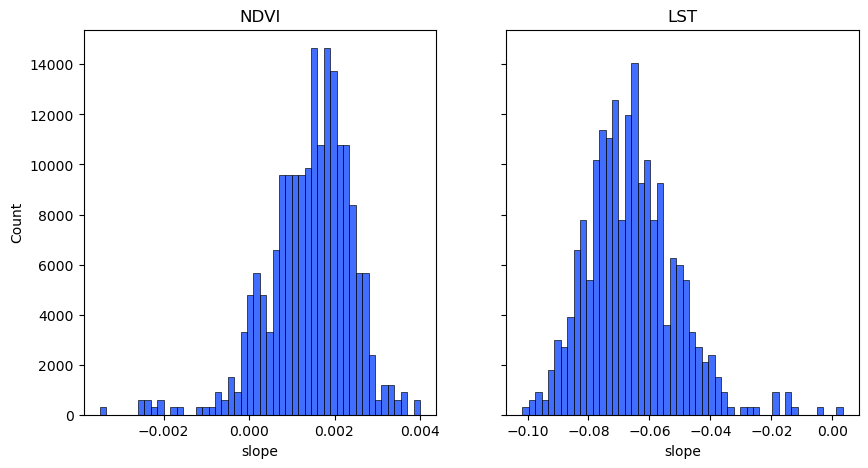

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.histplot(df_ndvi_w_mk, x="slope", bins=50, ax=ax1)
sns.histplot(df_lst_w_mk, x="slope",bins=50, ax=ax2)
ax1.set_title("NDVI", fontsize=12)
ax2.set_title("LST", fontsize=12)

plt.show()

## Vegetation Health Index 

The Vegetation Health Index (VHI) is a remote-sensing metric that can be used to assess drought risk by combining relative proportions of NDVI and LST data. The VHI depends on two quantities - the Vegetation Condition Index (VCI) and the Temperature Condition Index (TCI). The VCI and TCI are, in simple terms, scaled versions of the NDVI and LST and are defined as follows

$$ \text{VCI}_m = 100\cdot\frac{\text{NDVI}_m - \text{NDVI}_{m,\text{min}}}{\text{NDVI}_{m,\text{max}}-\text{NDVI}_{m,\text{min}}} $$

and,

$$ \text{TCI}_m = 100\cdot\frac{\text{LST}_m - \text{LST}_{m,\text{min}}}{\text{LST}_{m,\text{max}}-\text{LST}_{m,\text{min}}} $$

where the $m$ represents that month of observation and the min and max are historical minimum and maximum for that month (in general, the period can be anything). With these, the VHI is calculated as follows

$$ \text{VHI}_m = \alpha \text{VCI}_m + (1-\alpha)\text{TCI}_m $$
The factor $\alpha$ is often set to 0.5, indicating equal contributions arising from VCI and TCI. The VHI should ideally be measured during growing seasons. This can be difficult to assess, especially with MODIS NDVI data. As a result, we use a simple threshold based approach to label months falling in the growing seasons. For each year, the NDVI threshold is computed as $\text{NDVI}_{\text{thresh}} = \text{NDVI}_{\text{min}} + 0.2\left( \text{NDVI}_{\text{max}}-\text{NDVI}_{\text{min}} \right)$. During these periods, the VHI is classified as follows (with integer codings)-
* $\text{VHI} > 40$: no drought (0)
* $30\leq\text{VHI}< 40$: mild drought (1)
* $20\leq\text{VHI}< 30$: moderate drought (2)
* $10\leq\text{VHI}< 20$: severe drought (3)
* $\text{NDVI}< 10$: extreme drought (4)

We should note that the VHI has its shortcomings. Without performing a correlation analysis with other drought risk indices, the $\alpha$ factor cannot be properly tuned. Moreover, in this form, the VHI does not take into account precipitation, which is an important factor related to drought risk.

### Tuning $\alpha$ using PDSI

The free parameter $\alpha$ can be tuned by maximizing its Pearson correlation with another drought index - the 'Palmer Drought Severity Index' (PDSI). The PDSI can be considered to be a more robust metric since it combines key indicators such as evapotranspiration and soil water capacity. PDSI data can be obtained from GEE's `TerraClimate` dataset. However, the PDSI data has a lower resolution and is, generally, excellent for broader survery regions. For this work, we find use a gridded set of $\alpha$ values and find possible values for which the Pearson correlation coefficient is positive for a majority of the tiles. 

In [14]:
def VHI(df_ndvi: pd.DataFrame, df_lst: pd.DataFrame, a: float=0.5) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    This function calculates the `Vegetation Health Index` (VHI) from the NDVI 
    time-series data by calculating the `Vegetation Condition Index` (VCI) and
    `Temperature Condition Index` (TCI)

    VCI_m = 100*( (NDVI_m - NDVI_m,min) / (NDVI_m,max - NDVI_m,min) )

    where the subscript m represents the current month with NDVI_m,min and NDVI_m,max representing
    the minimum and maximum NDVI for that month. Similarly, 
    TCI_m = 100*( (LST_m - LST_m,min) / (LST_m,max - LST_m,min) )

    Finally, VCI = a * VCI + (1 - a) * TCI

    where `a` is a free parameter often chosen to be 0.5. 
    """

    # Calculate NDVI and LST min/max for given aggregation period (months in this case)
    ndvi_min_max = df_ndvi.groupby(["tile_name", "month"])[["ndvi"]].agg(
        ndvi_period_min=pd.NamedAgg(column="ndvi", aggfunc="min"),
        ndvi_period_max=pd.NamedAgg(column="ndvi", aggfunc="max")
    ).reset_index()

    lst_min_max = df_lst.groupby(["tile_name", "month"])[["lst"]].agg(
        lst_period_min=pd.NamedAgg(column="lst", aggfunc="min"),
        lst_period_max=pd.NamedAgg(column="lst", aggfunc="max")
    ).reset_index()

    df_VCI = df_ndvi.merge(ndvi_min_max, on=["tile_name", "month"], how="inner")
    df_TCI = df_lst.merge(lst_min_max, on=["tile_name", "month"], how="inner")

    df_VCI["VCI"] = 100 * ( df_VCI["ndvi"] - df_VCI["ndvi_period_min"] ) / ( df_VCI["ndvi_period_max"] - df_VCI["ndvi_period_min"] )
    df_TCI["TCI"] = 100 * ( df_TCI["lst"] - df_TCI["lst_period_min"] ) / ( df_TCI["lst_period_max"] - df_TCI["lst_period_min"] )

    df_VHI = df_VCI.merge(df_TCI, on=["tile_name", "month", "year", "date"], how="inner")

    df_VHI["VHI"] = a*df_VHI["VCI"] + (1 - a)*df_VHI["TCI"]

    """
    VHI thresholds should ideally be used during crop growing seasons. We use a
    threshold based approach.
    """
    df_thresh = df_ndvi.groupby(["tile_name", "year"])["ndvi"].agg(
        ndvi_min="min",
        ndvi_max="max"
    ).reset_index()

    df_thresh["threshold"] = (
        df_thresh["ndvi_min"] + 0.2 * (df_thresh["ndvi_max"] - df_thresh["ndvi_min"])
    )

    df_VHI_w_thresh = df_VHI.merge(df_thresh[["tile_name", "year", "threshold"]],
                                   on=["tile_name", "year"],
                                   how="left")

    # Create a binary growing_season column based on threshold  
    df_VHI_w_thresh["growing_season"] = df_VHI_w_thresh["ndvi"] > df_VHI_w_thresh["threshold"]
    # df_VHI_w_thresh["drought_like_condition"] = (
    #     (df_VHI_w_thresh["growing_season"]==True) & (df_VHI_w_thresh["VHI"] < 40)
    # ).astype(int)
    def drought_categories(row):
        if not row["growing_season"]:
            return -1 
        if row["growing_season"]:
            if row["VHI"] >= 40:
                return 0 
            elif (row["VHI"] < 40) & (row["VHI"] >= 30):
                return 1 
            elif (row["VHI"] < 30) & (row["VHI"] >= 20):
                return 2
            elif (row["VHI"] < 20) & (row["VHI"] >= 10):
                return 3
            else:
                return 4

    df_VHI_w_thresh["drought_like_months"] = df_VHI_w_thresh.apply(drought_categories, axis=1)

    return df_VHI_w_thresh

INFO:root:Creating monthly aggregate.


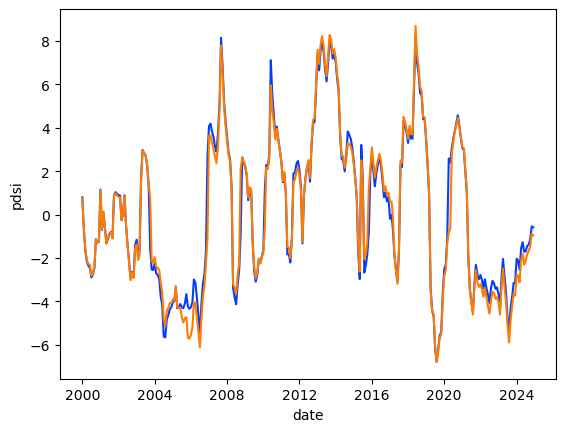

In [15]:
df_pdsi, _ = clean_ts_data(
    bucket_name="terraclimate-time-series", 
    key="TERRACLIMATE_pdsi_series_Trans_Nzoia_1.csv",
    var="pdsi"
)

df_pdsi_sample = df_pdsi[df_pdsi["tile_name"]==0]

sns.lineplot(df_pdsi[df_pdsi["tile_name"]==0], x="date", y="pdsi")
sns.lineplot(df_pdsi[df_pdsi["tile_name"]==10], x="date", y="pdsi")
plt.show()

The plot below shows the cross-correlations between VHI and PDSI for $\alpha=0.75$ for each tile. Unsuprisingly, there those not exist strong linear correlation between these two metrics since they are derived using different types of indicators.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_275/2207396778.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_cross_corrs, x="tile_name", y="cross_corr", palette=colors, ax=ax)
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


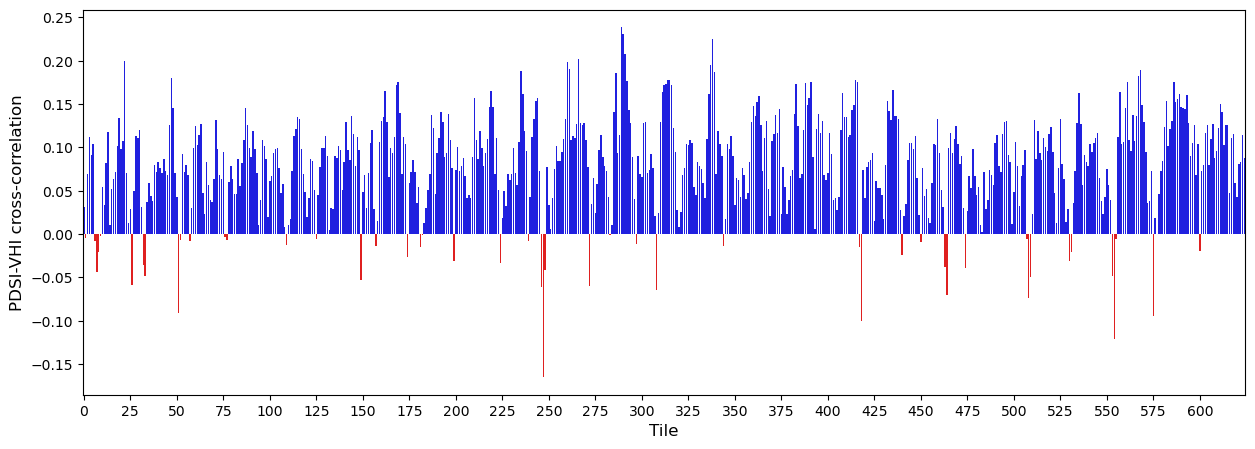

In [16]:
def VHI_PDSI_corr(df_ndvi, df_lst, df_pdsi, a):


    df_VHI = VHI(df_ndvi, df_lst, a=a)

    df_merged = df_VHI.merge(df_pdsi, on=["tile_name", "year", "month", "date"], how="left")

    df_corr_per_tile = df_merged.groupby("tile_name")[["VHI", "pdsi"]].corr().reset_index()
    df_cross_corrs = df_corr_per_tile.groupby("tile_name")[["pdsi"]].agg(
        cross_corr=pd.NamedAgg(column="pdsi", aggfunc="first")
    ).reset_index()

    fig, ax = plt.subplots(figsize=(15, 5))
    xticks = [i for i in range(0, len(df_cross_corrs), 25)]
    colors = ["blue" if cross_corr >=0 else "red" for cross_corr in df_cross_corrs["cross_corr"]]

    sns.barplot(df_cross_corrs, x="tile_name", y="cross_corr", palette=colors, ax=ax)
    ax.set_xlabel("Tile", fontsize=12)
    ax.set_ylabel("PDSI-VHI cross-correlation", fontsize=12)
    ax.set_xticks(xticks)

    plt.show()

VHI_PDSI_corr(df_ndvi, df_lst, df_pdsi, a=0.75)

## Quantifying drought-like events

Using the VHI, we can quantify two types of drought-like events. 'Drought-like months' are months where the VHI dip below 40. This category can be further divided into the mild, moderate, extreme and severe subcategories. However, isolated drought-like months might not be meaningful in the context of drought risk assessment. As a result, we can define 'drought-like periods' as those events where the VHI is below 40 for atleast 3 consecutive months, which gives a better indication of dry spells.

In [17]:
df_VHI = VHI(df_ndvi, df_lst, a=0.75)

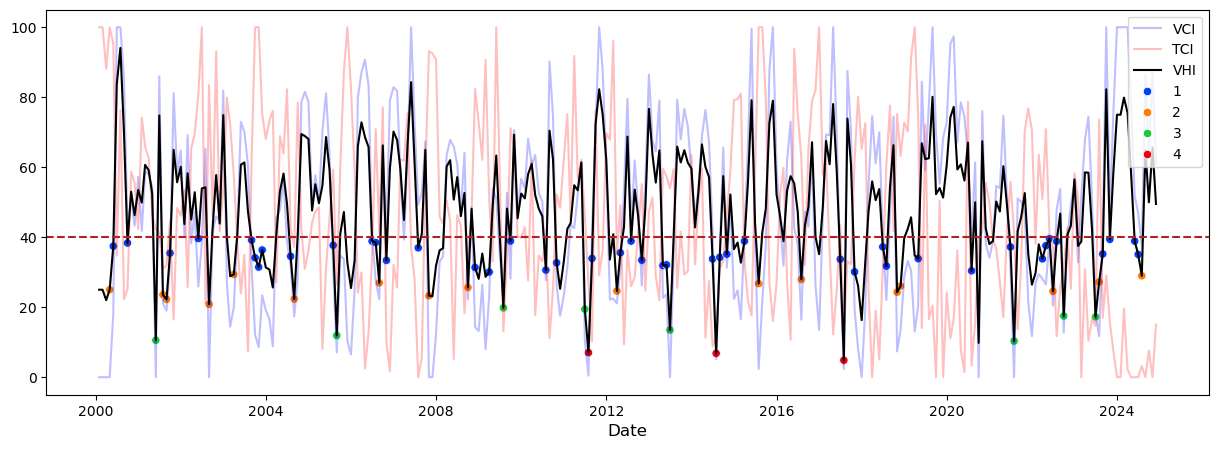

In [18]:
df_VHI_sample = df_VHI[df_VHI["tile_name"]==0]

fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(df_VHI_sample, x="date", y="VCI", ax=ax, label="VCI", color="blue", alpha=0.25)
sns.lineplot(df_VHI_sample, x="date", y="TCI", ax=ax, label="TCI", color="red", alpha=0.25)
sns.lineplot(df_VHI_sample, x="date", y="VHI", ax=ax, label="VHI", color="black")

sns.scatterplot(df_VHI_sample[df_VHI_sample["drought_like_months"]>0], x="date", y="VHI", ax=ax, hue="drought_like_months", palette="bright")

plt.axhline(40, linestyle="dashed", color="firebrick")

ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("")

plt.legend(loc="upper right")
plt.show()

### Drought-like months heatmap

Below, we plot heatmaps for drought-like months for each category. Each tile experiences several drought-like months with the presence of a cluster of high counts along the western edge of the region. However, this map simply displays the counts of months where $\text{VHI}<40$ and might not be representative of extended dry periods.

In [19]:
def plot_drought_months_map(df_VHI: pd.DataFrame, gdf: gpd.GeoDataFrame) -> None:
    import matplotlib as mpl

    drought_category = {
        1: "Mild",
        2: "Moderate",
        3: "Extreme",
        4: "Severe"
    }

    fig, ax = plt.subplots(1, 4, figsize=(15, 7), sharey=True)

    for i in range(4):
    # Count total drought-like occurrences per tile
        df_VHI_agg = df_VHI[df_VHI["drought_like_months"]==i+1].groupby(["tile_name"]).agg(
            drought_count=("drought_like_months", "count")
        ).reset_index()

        gdf_agg = gpd.GeoDataFrame(
            df_VHI_agg.merge(gdf, on="tile_name", how="inner")
        )

        cmap = "RdYlGn_r"
        vmin = gdf_agg["drought_count"].min()
        vmax = gdf_agg["drought_count"].max()

        gdf_agg.plot(
            column="drought_count",
            cmap=cmap, 
            legend=False,
            vmin=vmin,
            vmax=vmax,
            ax=ax[i]
        )

        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm._A = []  # Needed to avoid a matplotlib warning

        cbar = fig.colorbar(sm, ax=ax[i], location="bottom")
        #cbar.set_label("Number of Drought-like Events", fontsize=10)

        ax[i].set_xlabel("Longitude", fontsize=12)

        if i == 0:
            ax[i].set_ylabel("Latitude", fontsize=12)

        ax[i].set_title(f"{drought_category[i+1]} drought", fontsize=12)
    plt.suptitle("Number of potential drought months in Trans-Nzoia (2000 to 2024)", fontsize=15, y=0.85)
    plt.tight_layout()
    plt.show()

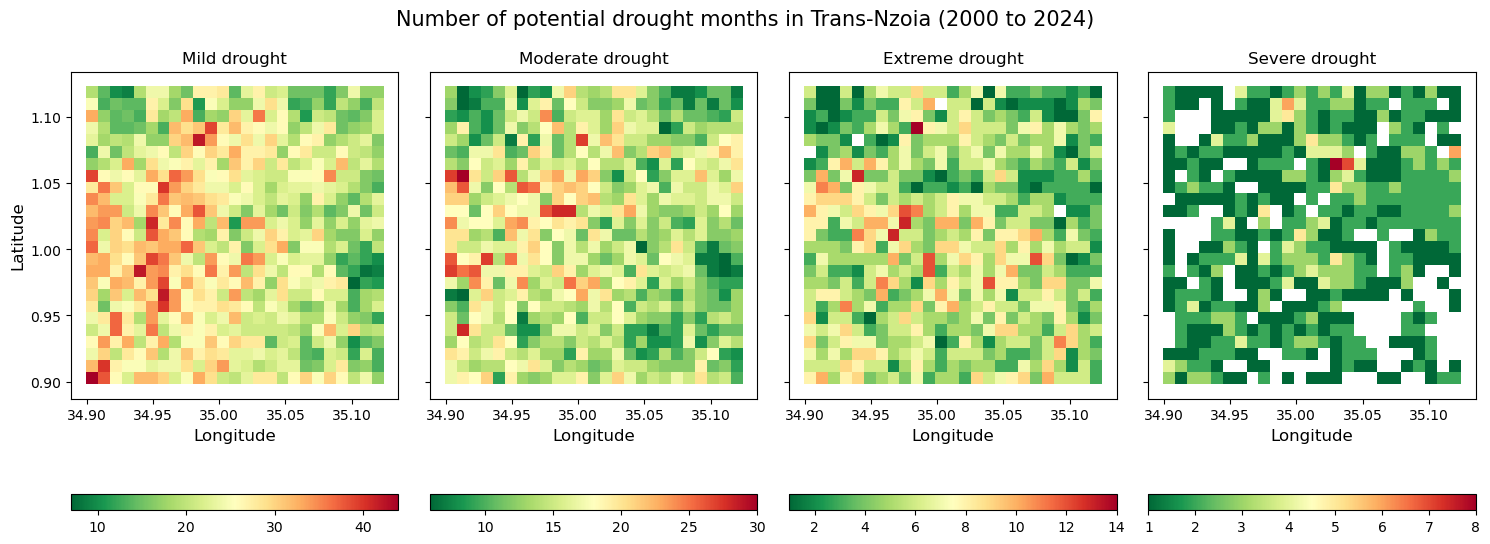

In [20]:
plot_drought_months_map(df_VHI, gdf)

### Drought-like periods heatmap

Taking into account more extended periods where $\text{VHI}<40$, we can produce a heatmap of drought-like periods, as shown below. Like before, we can clearly see the existence of more drought-like periods along the western edge of the region. This might be explained by regional differences in the NDVI time-series and it will be worthwhile to determine if correlations exist between this and iSDA soil data.

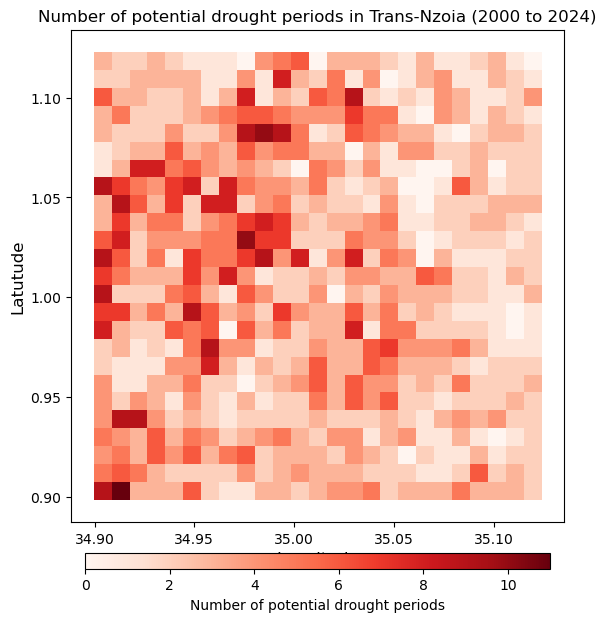

In [21]:
def plot_drought_like_periods(df_VHI: pd.DataFrame, gdf: gpd.GeoDataFrame) -> None:
    import matplotlib as mpl
    def find_consecutive_sequences(nums):
        if not nums:
            return []

        nums = sorted(set(nums))  # Remove duplicates and sort
        result = []
        temp = [nums[0]]

        for i in range(1, len(nums)):
            if nums[i] == nums[i - 1] + 1:
                temp.append(nums[i])
            else:
                if len(temp) >= 3:
                    result.append(temp)
                temp = [nums[i]]

        if len(temp) >= 3:
            result.append(temp)

        return len(result)

    drought_event_counts = {"tile_name": [], "n_drought_events": []}
    for tile, group in df_VHI[df_VHI["drought_like_months"]>0].groupby("tile_name"):
        drought_like_months = group.index.tolist()
        drought_events = find_consecutive_sequences(drought_like_months)

        drought_event_counts["tile_name"].append(tile)
        drought_event_counts["n_drought_events"].append(drought_events)

    df_drought_events = pd.DataFrame.from_dict(drought_event_counts)
    gdf_drought_events = gpd.GeoDataFrame(
        df_drought_events.merge(gdf, on="tile_name", how="inner")
    )
    
    fig, ax = plt.subplots(figsize=(8, 8))

    vmin = gdf_drought_events["n_drought_events"].min()
    vmax = gdf_drought_events["n_drought_events"].max()

    cmap = "Reds"

    gdf_drought_events.plot(
        column="n_drought_events",
        cmap=cmap,
        legend=False,
        ax=ax
    )    

    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latutude", fontsize=12)

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Needed to avoid a matplotlib warning

    cbar = fig.colorbar(sm, ax=ax, location="bottom", shrink=0.75, aspect=30, pad=0.05)
    cbar.set_label("Number of potential drought periods")

    ax.set_title("Number of potential drought periods in Trans-Nzoia (2000 to 2024)", fontsize=12)

plot_drought_like_periods(df_VHI, gdf)
        

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

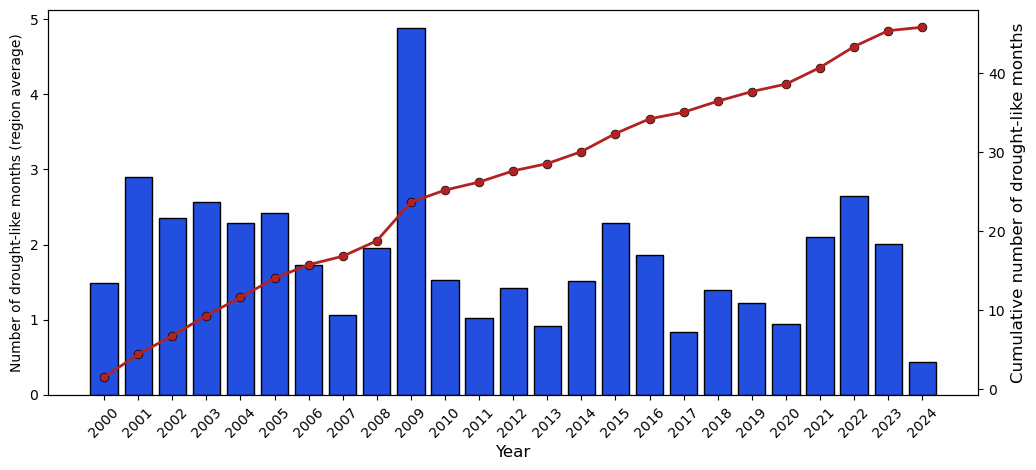

In [22]:
def plot_drought_months_bars(df_VHI: pd.DataFrame) -> None:
    df = df_VHI.copy()

    N = len(df_VHI["tile_name"].unique()) 

    df["period"] = df["year"].apply(
        lambda x: "2000 to 2010" if ((x >= 2000) & (x < 2010)) 
                  else "2010 to 2020" if ((x >= 2010) & (x < 2020)) 
                  else "2020 onwards"
    )

    df_subset = df[
        (df["growing_season"]==True)
        &
        (df["drought_like_months"]>0)
    ]

    # fig, ax = plt.subplots(figsize=(12, 5))

    # sns.countplot(df_subset, x="month", hue="period", edgecolor="k", ax=ax)
    # ax.set_xlabel("Month", fontsize=12)
    # ax.set_ylabel("Drought-like months", fontsize=12)

    # plt.show()
    df_subset = df_subset.groupby(["year"])[["tile_name"]].agg(
        counts=pd.NamedAgg(column="tile_name", aggfunc="count")
    ) / N

    df_subset = df_subset.reset_index()
    df_subset["year"] = df_subset["year"].astype(str)
    df_subset["cum_counts"] = df_subset["counts"].cumsum()

    fig, ax1 = plt.subplots(figsize=(12, 5))

    sns.barplot(data=df_subset, x="year", y="counts", edgecolor="k", ax=ax1)
    ax1.set_xlabel("Year", fontsize=12)
    ax1.set_ylabel("Number of drought-like months (region average)")

    ax1.tick_params(axis='x', rotation=45)

    ax2 = ax1.twinx()

    sns.lineplot(data=df_subset, x="year", y="cum_counts", linewidth=2, color="firebrick", ax=ax2)
    sns.scatterplot(data=df_subset, x="year", y="cum_counts", s=40, color="firebrick", edgecolor="k", ax=ax2)
    ax2.set_ylabel("Cumulative number of drought-like months", fontsize=12)

    plt.show()

    return df_subset

blah = plot_drought_months_bars(df_VHI)